# Study of the error sources

## Shot noise


It refers to the statistical noise or fluctuations that arise when measuring the outcomes of quantum circuits executed on quantum hardware. Shot noise specifically describes the variability in the results due to the finite number of measurements (or shots) taken, which is a form of statistical uncertainty. Since, quantum measurements are inherently probabilistic, repeated measurements of a quantum state will yield a distribution rather than a deterministic output, thereby leading in some variability in the observed counts of each possible outcome. This variability is shot noise, a type of sampling noise.


Let's see this error by fixing all parameters and changing the number of `default_shots` specified in `EstimatorOptions`.

In [ ]:
from main_functions.ME_solver import solve_master_equation
from main_functions.original_circuit import get_circuit
from main_functions.estimator_solver import estimator_solver
from qiskit_aer import AerSimulator
import numpy as np

omega_c = 1.1
n = 2
kappa = [0.2]
omega_m = [1.1]*n
g = [0.01]*(2*(n-1))
gamma = [0.8*(10**-6)]*n
initial_state = [0]*(2**n)
initial_state[-1] = 1

t = np.linspace(0, 750, 250)

backend = AerSimulator()
optimization_level = 0

qc_populations = {}
qutip_populations = {}
r = 9

shots = [10**2, 10**3, 10**4, 10**5, 10**6]

results = []
results.append(t)

for s in shots:

    options = {'default_shots' : s}

    qc = get_circuit(n, omega_m, omega_c, g, gamma, kappa, initial_state, r)
    evs_qc = estimator_solver(qc, n, t, backend, optimization_level, options)
    results.append(evs_qc['0'])
    print(f'shots = {s} finished!')

evs_qutip = solve_master_equation(n, omega_m, omega_c, gamma, kappa, g, t, initial_state, 'markovian')
results.append(evs_qutip['0'])

np.savetxt('data/shots_comparison_9_trotter.txt', np.column_stack(results), delimiter = ' ', header = 't s=10**2 s=10**3 s=10**4 s=10**5 s=10**6 qutip')

shots = 100 finished!


c:\Users\Benjamin\iCloudDrive\PhD\Quantum Computing\dissipative dynamics\main_functions\efficient_qiskit_solver_markovian_CHAIN.py:117: SyntaxWarning: invalid escape sequence '\P'
  """


KeyboardInterrupt: 

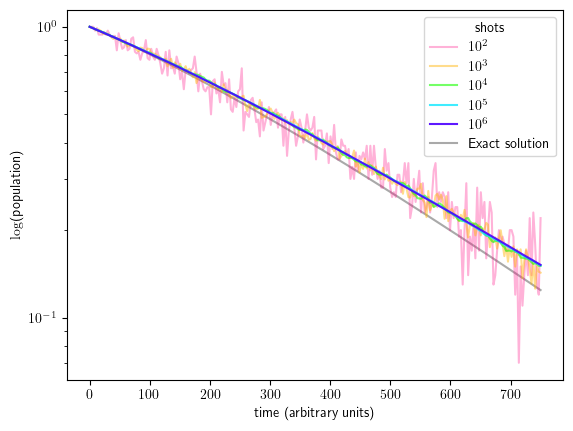

In [17]:
from utils.generate_complementary_colors import generate_complementary_colors
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

shots = [10**2, 10**3, 10**4, 10**5, 10**6]

colors = generate_complementary_colors(len(shots), 'neon', 'hotpink')

qutip = np.loadtxt('data/shots_comparison_5_trotter.txt', usecols = 5, skiprows = 1)
plt.plot(t, qutip, color = 'darkgrey')

tr = 0.3

for i in range(len(shots)):

    data = np.loadtxt('data/shots_comparison_5_trotter.txt', usecols = i, skiprows = 1)
    plt.plot(t, data, color = colors[i], label = f'$10^{i+2}$', alpha = tr)
    tr = tr + 0.15

plt.plot(np.NaN, np.NaN, color = 'darkgrey', label = 'Exact solution')

plt.ylabel('$\\log$(population)')
plt.xlabel('time (arbitrary units)')
plt.yscale('log')
plt.legend(title = 'shots')
plt.savefig('figures/shots_comparison.png')
plt.show()


## Trotter error of the Hamiltonian evolution.

Using the Baker-Campbell-Hausdorff formula,


$$ 
\begin{align}
e^{-itA} e^{-itB} = e^{-it(A+B) - i \frac{t^2}{2} [A,B] + i \frac{t^3}{12} [A, [A,B]] - i \frac{t^3}{12} [B, [A,B]]} + \dots
\end{align}

So approximating $e^{-it(A+B)} \approx e^{-itA} e^{-itB}$ (i.e., truncating the expansion at first order) comes at the cost of introducing an error that can be upper bounded by taking the norm of the second term,

$$
\begin{align}
\left| \left| -i \frac{t^2}{2} [A,B] \right| \right| = \frac{t^2}{2} \left|\left| [A,B] \right| \right|
\end{align}

In big $\mathcal{O}$ notation,

$$
\begin{align}
e^{-it(A+B)} = e^{-itA} e^{-itB} + \mathcal{O} \left( \frac{t^2}{2} \left|\left| [A,B] \right| \right| \right)
\end{align}

(the $\frac{1}{2}$ is typically omitted in this notation). In the context of the Trotter decomposition, $t \to t/r $, where $r$ is the number of Trotter steps, and

$$
\begin{align}
\epsilon_{per step} \sim \frac{t^2}{2r^2} \left|\left| [A,B] \right|\right|
\end{align}

For the two emitters case, $A = H_0$ and $B = H_I$ and 

$$
\begin{align}
|| [H_0, H_I] || = \tilde{g} | \tilde{\omega}_1 - \tilde{\omega}_2 | \cdot \left|\left| \sigma_0^{\dag} \sigma_1 - \sigma_0 \sigma_1^{\dag} \right|\right| = \sqrt{2} \tilde{g} | \tilde{\delta} |
\end{align}

with $\tilde{\delta} \equiv \tilde{\omega}_1 - \tilde{\omega}_0$ the relative detuning between the emtiters. In the particular case $\tilde{\omega}_0 = \tilde{\omega_1}$, the commutator above vanishes, meaning that there is no Trotter error per step so we know that the partition $e^{-it(H_0 + H_I)} = e^{-iH_0t} e^{-iH_It}$ is exact.

We also need to Trotterize $H_I$ so now,

$$
\begin{align}
e^{-iH_I t} = e^{-i \tilde{g} (\sigma_0^{\dag} \sigma_1 + \sigma_0 \sigma_1^{\dag})t} = e^{-i\tilde{g}t \sigma_0^{\dag} \sigma_1} e^{-i\tilde{g}t \sigma_0 \sigma_1^{\dag}} + \mathcal{O} \left( \frac{t^2}{4r^2} \left| \left| \left[ \tilde{g} \sigma_0^{\dag} \sigma_1, \tilde{g} \sigma_0 \sigma_1^{\dag} \right] \right| \right|  \right)
\end{align}

Computing the commutator yields


$$
\begin{align}
\left[ \tilde{g} \sigma_0^{\dag} \sigma_1, \tilde{g} \sigma_0 \sigma_1^{\dag} \right] = \tilde{g}^2 \left[ \left( \mathbf{1}_0 + Z_0\right)Z_1 + Z_0 \left( \mathbf{1}_1 + Z_1\right) \right] = \tilde{g}^2 \left( Z_0 + Z_1 + 2Z_0 Z_1\right)
\end{align}

The norm of the resulting matrix is $2\sqrt{6}$, so

$$
\begin{align}
\left|\left| \left[ \tilde{g} \sigma_0^{\dag} \sigma_1, \tilde{g} \sigma_0 \sigma_1^{\dag} \right] \right| \right| \approx 2\sqrt{6} \tilde{g}^2 
\end{align}

And as a result

$$
\begin{align}
\epsilon_{per step} \sim \frac{t^2}{2r^2} \left|\left| [A,B] \right|\right| \approx 2\sqrt{6} \tilde{g}^2 \left( \frac{t}{2r}\right)^2
\end{align}

To sum up, the total Trotter error per step for the coherent evolution can be approximated as

$$
\begin{align}
\epsilon_{trotter} = \left( \sqrt{2} \tilde{g} | \tilde{\delta} | + 2\sqrt{6} \tilde{g}^2 \right)\left( \frac{t}{2r}\right)^2
\end{align}

## Kraus implementation error

First of all, recall that we are implementing a series of four quantum channels.

\begin{align*}
\left| G \right>_S \otimes \left|0 \right>_E &\to \left| G \right>_S \otimes \left|0 \right>_E \\
\left| \Lambda_+ \right>_S \otimes \left|0 \right>_E &\to \sqrt{1- p_{G+}} \left| \Lambda_+ \right>_S \otimes \left|0 \right>_E +  \sqrt{p_{G+}} \left| G \right>_S \otimes \left|1 \right>_E
\end{align*}

\begin{align*}
\left| \Lambda_+ \right>_S \otimes \left|0 \right>_E &\to \left| \Lambda_+  \right>_S \otimes \left|0 \right>_E \\
\left| E \right>_S \otimes \left|0 \right>_E &\to \sqrt{1- p_{+E}} \left| E \right>_S \otimes \left|0 \right>_E +  \sqrt{p_{+E}} \left| \Lambda_+ \right>_S \otimes \left|1 \right>_E
\end{align*}

\begin{align*}
\left| G \right>_S \otimes \left|0 \right>_E &\to \left| G \right>_S \otimes \left|0 \right>_E \\
\left| \Lambda_- \right>_S \otimes \left|0 \right>_E &\to \sqrt{1- p_{G-}} \left| \Lambda_- \right>_S \otimes \left|0 \right>_E +  \sqrt{p_{G-}} \left| G \right>_S \otimes \left|1 \right>_E
\end{align*}

\begin{align*}
\left| \Lambda_- \right>_S \otimes \left|0 \right>_E &\to \left| \Lambda_-  \right>_S \otimes \left|0 \right>_E \\
\left| E \right>_S \otimes \left|0 \right>_E &\to \sqrt{1- p_{-E}} \left| E \right>_S \otimes \left|0 \right>_E +  \sqrt{p_{-E}} \left| \Lambda_- \right>_S \otimes \left|1 \right>_E
\end{align*}

Using an ancilla register of size two to model the environment, we get the combined channel transformation equations.

\begin{align*}
\left| G \right>_S \otimes \left|00 \right>_E &\to \left| G \right>_S \otimes \left|0 \right>_E \\
\left| \Lambda_- \right>_S \otimes \left|00 \right>_E &\to \sqrt{1- p_{G-}} \left| \Lambda_- \right>_S \otimes \left|00 \right>_E +  \sqrt{p_{G-}} \left| G \right>_S \otimes \left|01 \right>_E \\
\left| \Lambda_+ \right>_S \otimes \left|00 \right>_E &\to \sqrt{1- p_{G+}} \left| \Lambda_+ \right>_S \otimes \left|00 \right>_E +  \sqrt{p_{G+}} \left| G \right>_S \otimes \left|10 \right>_E \\
\left| E \right>_S \otimes \left|00 \right>_E &\to \sqrt{1- p_{-E}}\sqrt{1- p_{+E}} \left| E \right>_S \otimes \left|00 \right>_E +  \sqrt{p_{+E}}\sqrt{1- p_{-E}} \left| \Lambda_+ \right>_S \otimes \left|01 \right>_E +  \sqrt{p_{-E}}\sqrt{1- p_{+E}} \left| \Lambda_- \right>_S \otimes \left|10 \right>_E +  \sqrt{p_{-E}}\sqrt{p_{+E}} \left| G \right>_S \otimes \left|11 \right>_E 
\end{align*}

This channel is CPTP and admits a Kraus decomposition (computed using the `get_kraus`function in `utils`)

In [1]:
from utils.get_kraus_TEST import get_kraus
from sympy import Matrix, Symbol, sqrt, latex
from IPython.display import display, Math
from sympy.physics.quantum import TensorProduct
from sympy import init_printing
init_printing()

ancilla_dim = 4
system_dim = 4

p_plus = Symbol('p_{+}')
p_minus = Symbol('p_{-}')

# p_plus_e = Symbol('p_{+E}')
# p_minus_e = Symbol('p_{-E}')
# p_g_plus = Symbol('p_{G+}')
# p_g_minus = Symbol('p_{G-}')

p_plus_e = p_plus
p_minus_e = p_minus
p_g_plus = p_plus
p_g_minus = p_minus

ket_0 = Matrix([[1],[0]])
ket_1 = Matrix([[0],[1]])

ket_00 = TensorProduct(ket_0, ket_0)
ket_01 = TensorProduct(ket_0, ket_1)
ket_10 = TensorProduct(ket_1, ket_0)
ket_11 = TensorProduct(ket_1, ket_1)

first_prime = TensorProduct(ket_00, ket_00) 
second_prime = sqrt(1-p_g_minus)*TensorProduct(ket_01, ket_00) + sqrt(p_g_minus)*TensorProduct(ket_00, ket_01)
third_prime = sqrt(1-p_g_plus)*TensorProduct(ket_10, ket_00) + sqrt(p_g_plus)*TensorProduct(ket_00, ket_10)
fourth_prime = sqrt(1-p_plus_e)*sqrt(1-p_minus_e)*TensorProduct(ket_11, ket_00) + sqrt(1 - p_plus_e)*sqrt(p_minus_e)*TensorProduct(ket_01, ket_10) + sqrt(1 - p_minus_e)*sqrt(p_plus_e)*TensorProduct(ket_10, ket_01) +sqrt(p_minus_e)*sqrt(p_plus_e)*TensorProduct(ket_00, ket_11) 

transformed_kets = [first_prime, second_prime, third_prime, fourth_prime]
basis = 'computational'

kraus = get_kraus(transformed_kets, basis, system_dim, ancilla_dim, True)
counter = 0
for k in kraus:
    eq_latex = f'K_{counter} = ' + latex(k)
    display(Math(eq_latex))
    counter = counter + 1

The channel is CPTP


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [2]:
from sympy import print_latex

for k in kraus:
    print_latex(k)

\left[\begin{matrix}1 & 0 & 0 & 0\\0 & \sqrt{1 - p_{-}} & 0 & 0\\0 & 0 & \sqrt{1 - p_{+}} & 0\\0 & 0 & 0 & \sqrt{1 - p_{+}} \sqrt{1 - p_{-}}\end{matrix}\right]
\left[\begin{matrix}0 & \sqrt{p_{-}} & 0 & 0\\0 & 0 & 0 & 0\\0 & 0 & 0 & \sqrt{p_{+}} \sqrt{1 - p_{-}}\\0 & 0 & 0 & 0\end{matrix}\right]
\left[\begin{matrix}0 & 0 & \sqrt{p_{+}} & 0\\0 & 0 & 0 & \sqrt{p_{-}} \sqrt{1 - p_{+}}\\0 & 0 & 0 & 0\\0 & 0 & 0 & 0\end{matrix}\right]
\left[\begin{matrix}0 & 0 & 0 & \sqrt{p_{+}} \sqrt{p_{-}}\\0 & 0 & 0 & 0\\0 & 0 & 0 & 0\\0 & 0 & 0 & 0\end{matrix}\right]


Using these Kraus operators, we can compute the evolution of the density matrix under the effects of the quantum channel, after one application of the channel $t \to t +\Delta t$

In [9]:
from sympy import Function, Matrix
import numpy as np

symbol_data = []

for i in range(4):
    row = []

    for j in range(4):
        row.append(Function(f"rho_{i}{j}")(Symbol('0')))
    
    symbol_data.append(row)

rho = Matrix(symbol_data)
kraus_rho = kraus[0]*(rho*kraus[0].transpose()) + kraus[1]*(rho*kraus[1].transpose()) + kraus[2]*(rho*kraus[2].transpose()) + kraus[3]*(rho*kraus[3].transpose())

eq_latex = r'\rho_{Kraus}(t + \Delta t) =' + latex(kraus_rho)
display(Math(eq_latex))

<IPython.core.display.Math object>

In [10]:
from sympy.printing.latex import latex

# Custom LaTeX rendering for functions
def custom_latex(expr):
    return latex(expr).replace(r'\rho_', r"\rho'_")

print(custom_latex(kraus_rho))

\left[\begin{matrix}p_{+} p_{-} \rho'_{33}{\left(0 \right)} + p_{+} \rho'_{22}{\left(0 \right)} + p_{-} \rho'_{11}{\left(0 \right)} + \rho'_{00}{\left(0 \right)} & \sqrt{p_{+}} \sqrt{p_{-}} \sqrt{1 - p_{+}} \rho'_{23}{\left(0 \right)} + \sqrt{1 - p_{-}} \rho'_{01}{\left(0 \right)} & \sqrt{p_{+}} \sqrt{p_{-}} \sqrt{1 - p_{-}} \rho'_{13}{\left(0 \right)} + \sqrt{1 - p_{+}} \rho'_{02}{\left(0 \right)} & \sqrt{1 - p_{+}} \sqrt{1 - p_{-}} \rho'_{03}{\left(0 \right)}\\\sqrt{p_{+}} \sqrt{p_{-}} \sqrt{1 - p_{+}} \rho'_{32}{\left(0 \right)} + \sqrt{1 - p_{-}} \rho'_{10}{\left(0 \right)} & p_{-} \left(1 - p_{+}\right) \rho'_{33}{\left(0 \right)} + \left(1 - p_{-}\right) \rho'_{11}{\left(0 \right)} & \sqrt{1 - p_{+}} \sqrt{1 - p_{-}} \rho'_{12}{\left(0 \right)} & \sqrt{1 - p_{+}} \left(1 - p_{-}\right) \rho'_{13}{\left(0 \right)}\\\sqrt{p_{+}} \sqrt{p_{-}} \sqrt{1 - p_{-}} \rho'_{31}{\left(0 \right)} + \sqrt{1 - p_{+}} \rho'_{20}{\left(0 \right)} & \sqrt{1 - p_{+}} \sqrt{1 - p_{-}} \rho'_{21}{\le

In [13]:
print_latex(kraus_rho)

\left[\begin{matrix}p_{+E} p_{-E} \operatorname{rho'}_{33}{\left(t \right)} + p_{G+} \operatorname{rho'}_{22}{\left(t \right)} + p_{G-} \operatorname{rho'}_{11}{\left(t \right)} + \operatorname{rho'}_{00}{\left(t \right)} & \sqrt{p_{-E}} \sqrt{p_{G+}} \sqrt{1 - p_{+E}} \operatorname{rho'}_{23}{\left(t \right)} + \sqrt{1 - p_{G-}} \operatorname{rho'}_{01}{\left(t \right)} & \sqrt{p_{+E}} \sqrt{p_{G-}} \sqrt{1 - p_{-E}} \operatorname{rho'}_{13}{\left(t \right)} + \sqrt{1 - p_{G+}} \operatorname{rho'}_{02}{\left(t \right)} & \sqrt{1 - p_{+E}} \sqrt{1 - p_{-E}} \operatorname{rho'}_{03}{\left(t \right)}\\\sqrt{p_{-E}} \sqrt{p_{G+}} \sqrt{1 - p_{+E}} \operatorname{rho'}_{32}{\left(t \right)} + \sqrt{1 - p_{G-}} \operatorname{rho'}_{10}{\left(t \right)} & p_{-E} \left(1 - p_{+E}\right) \operatorname{rho'}_{33}{\left(t \right)} + \left(1 - p_{G-}\right) \operatorname{rho'}_{11}{\left(t \right)} & \sqrt{1 - p_{G+}} \sqrt{1 - p_{G-}} \operatorname{rho'}_{12}{\left(t \right)} & \sqrt{1 - p_{+E}} 

We can now compare this output density matrix with the one obtained evolving $\rho$ under the (purely dissipative) Markovian Master equation, under the diagonal dissipators approximation (i.e., considering only the four diagonal dissipators in the coupled basis $\mathcal{D}(\sigma_{G+}), \mathcal{D}(\sigma_{G-}), \mathcal{D}(\sigma_{-E}), \mathcal{D}(\sigma_{+E})$)

In [ ]:
import sympy as sp

# Coupled basis definition

gr = Matrix([[1],[0],[0],[0]])
lambda_minus = Matrix([[0],[1],[0],[0]])
lambda_plus = Matrix([[0],[0],[1],[0]])
e = Matrix([[0],[0],[0],[1]])

# Operators definition

sigma_gplus = gr*lambda_plus.transpose()
sigma_gminus = gr*lambda_minus.transpose()
sigma_pluse = lambda_plus*e.transpose()
sigma_minuse = lambda_minus*e.transpose()

# Decay constants

gamma_plus = Symbol(r'\gamma_{+}')
gamma_minus = Symbol(r'\gamma_{-}')

# gamma_plus_e = Symbol(r'\gamma_{+E}')
# gamma_minus_e = Symbol(r'\gamma_{-E}')
# gamma_g_plus = Symbol(r'\gamma_{G+}')
# gamma_g_minus = Symbol(r'\gamma_{G-}')
# gamma_g_plus_plus_e = Symbol(r'\gamma_{G+, +E}')
# gamma_g_minus_minus_e = Symbol(r'\gamma_{G-, -E}')

gamma_plus_e = gamma_plus
gamma_minus_e = gamma_minus
gamma_g_plus = gamma_plus
gamma_g_minus = gamma_minus
gamma_g_plus_plus_e = gamma_plus
gamma_g_minus_minus_e = gamma_minus


# (Diagonal) Dissipators

d_gplus = gamma_g_plus*(sigma_gplus*rho*sigma_gplus.transpose() - 0.5*(sigma_gplus.transpose()*sigma_gplus*rho + rho*sigma_gplus.transpose()*sigma_gplus))
d_gminus = gamma_g_minus*(sigma_gminus*rho*sigma_gminus.transpose() - 0.5*(sigma_gminus.transpose()*sigma_gminus*rho + rho*sigma_gminus.transpose()*sigma_gminus))
d_pluse = gamma_plus_e*(sigma_pluse*rho*sigma_pluse.transpose() - 0.5*(sigma_pluse.transpose()*sigma_pluse*rho + rho*sigma_pluse.transpose()*sigma_pluse))
d_minuse = gamma_minus_e*(sigma_minuse*rho*sigma_minuse.transpose() - 0.5*(sigma_minuse.transpose()*sigma_minuse*rho + rho*sigma_minuse.transpose()*sigma_minuse))
d_gplus_pluse = gamma_g_plus_plus_e*(sigma_gplus*rho*sigma_pluse.transpose() - 0.5*(sigma_pluse.transpose()*sigma_gplus*rho + rho*sigma_pluse.transpose()*sigma_gplus))
d_pluse_gplus = gamma_g_plus_plus_e*(sigma_pluse*rho*sigma_gplus.transpose() - 0.5*(sigma_gplus.transpose()*sigma_pluse*rho + rho*sigma_gplus.transpose()*sigma_pluse))
d_gminus_minuse = gamma_g_minus_minus_e*(sigma_gminus*rho*sigma_minuse.transpose() - 0.5*(sigma_minuse.transpose()*sigma_gminus*rho + rho*sigma_minuse.transpose()*sigma_gminus))
d_minuse_gminus = gamma_g_minus_minus_e*(sigma_minuse*rho*sigma_gminus.transpose() - 0.5*(sigma_gminus.transpose()*sigma_minuse*rho + rho*sigma_gminus.transpose()*sigma_minuse))

drho_dt = sp.simplify(d_gplus + d_gminus+ d_pluse + d_minuse) # + d_gplus_pluse + d_pluse_gplus + d_gminus_minuse + d_minuse_gminus)
eq_latex = r'\frac{d \rho_{ME}}{dt} =' + latex(drho_dt)
display(Math(eq_latex))

<IPython.core.display.Math object>

In [30]:
print(custom_latex(drho_dt))

\left[\begin{matrix}\gamma_{+} \rho'_{22}{\left(t \right)} + \gamma_{-} \rho'_{11}{\left(t \right)} & - 0.5 \gamma_{-} \rho'_{01}{\left(t \right)} & - 0.5 \gamma_{+} \rho'_{02}{\left(t \right)} & 0.5 \left(- \gamma_{+} - \gamma_{-}\right) \rho'_{03}{\left(t \right)}\\- 0.5 \gamma_{-} \rho'_{10}{\left(t \right)} & \gamma_{-} \left(- 1.0 \rho'_{11}{\left(t \right)} + \rho'_{33}{\left(t \right)}\right) & 0.5 \left(- \gamma_{+} - \gamma_{-}\right) \rho'_{12}{\left(t \right)} & \left(- 0.5 \gamma_{+} - 1.0 \gamma_{-}\right) \rho'_{13}{\left(t \right)}\\- 0.5 \gamma_{+} \rho'_{20}{\left(t \right)} & 0.5 \left(- \gamma_{+} - \gamma_{-}\right) \rho'_{21}{\left(t \right)} & \gamma_{+} \left(- 1.0 \rho'_{22}{\left(t \right)} + \rho'_{33}{\left(t \right)}\right) & \left(- 1.0 \gamma_{+} - 0.5 \gamma_{-}\right) \rho'_{23}{\left(t \right)}\\0.5 \left(- \gamma_{+} - \gamma_{-}\right) \rho'_{30}{\left(t \right)} & \left(- 0.5 \gamma_{+} - 1.0 \gamma_{-}\right) \rho'_{31}{\left(t \right)} & \left(- 1.

In [15]:
print_latex(drho_dt)

\left[\begin{matrix}\gamma_{+} \operatorname{rho'}_{22}{\left(t \right)} + \gamma_{-} \operatorname{rho'}_{11}{\left(t \right)} & \gamma_{-} \left(- 0.5 \operatorname{rho'}_{01}{\left(t \right)} + \operatorname{rho'}_{13}{\left(t \right)}\right) & \gamma_{+} \left(- 0.5 \operatorname{rho'}_{02}{\left(t \right)} + \operatorname{rho'}_{23}{\left(t \right)}\right) & 0.5 \left(- \gamma_{+} - \gamma_{-}\right) \operatorname{rho'}_{03}{\left(t \right)}\\\gamma_{-} \left(- 0.5 \operatorname{rho'}_{10}{\left(t \right)} + \operatorname{rho'}_{31}{\left(t \right)}\right) & \gamma_{-} \left(- 1.0 \operatorname{rho'}_{11}{\left(t \right)} + \operatorname{rho'}_{33}{\left(t \right)}\right) & 0.5 \left(- \gamma_{+} - \gamma_{-}\right) \operatorname{rho'}_{12}{\left(t \right)} & \left(- 0.5 \gamma_{+} - 1.0 \gamma_{-}\right) \operatorname{rho'}_{13}{\left(t \right)}\\\gamma_{+} \left(- 0.5 \operatorname{rho'}_{20}{\left(t \right)} + \operatorname{rho'}_{32}{\left(t \right)}\right) & 0.5 \left(- \gamm

In [10]:
print_latex(rho)

\left[\begin{matrix}\rho_{00}{\left(t \right)} & \rho_{01}{\left(t \right)} & \rho_{02}{\left(t \right)} & \rho_{03}{\left(t \right)}\\\rho_{10}{\left(t \right)} & \rho_{11}{\left(t \right)} & \rho_{12}{\left(t \right)} & \rho_{13}{\left(t \right)}\\\rho_{20}{\left(t \right)} & \rho_{21}{\left(t \right)} & \rho_{22}{\left(t \right)} & \rho_{23}{\left(t \right)}\\\rho_{30}{\left(t \right)} & \rho_{31}{\left(t \right)} & \rho_{32}{\left(t \right)} & \rho_{33}{\left(t \right)}\end{matrix}\right]


Imagine now that we were applying both the ME and the quantum channel in small time steps, and consider the time evolution $t \to t + \Delta t$. In this context, we can approximate here $\frac{d\rho}{dt} \approx \frac{\rho (t+\Delta t) - \rho (t)}{\Delta t}$, allowing us to write the matrix equation above as

In [14]:
delta_t = Symbol(r'\Delta t')
symbol_data = []

for i in range(4):
    row = []

    for j in range(4):
        row.append(Function(f'rho_{i}{j}')(Symbol('t')))
    
    symbol_data.append(row)

evol_rho = Matrix(symbol_data) + sp.simplify(delta_t*drho_dt)
eq_latex = r'\rho_{ME} (t + \Delta t)=' + latex(evol_rho)
display(Math(eq_latex))

<IPython.core.display.Math object>

To explictly conect these two approaches (approximated ME and Kraus representation) we can define the decay probabilities for a small time evolution $t \to t + \Delta t$ as $ p_{\alpha}  = 1 - \exp ({-\gamma_{\alpha}t} )\approx \gamma_{\alpha} \Delta t$, with $\alpha = G+,G-,-E,+E$. With this, the Kraus evolution yields

In [17]:
substitutions = {p_plus_e : delta_t*gamma_plus_e,
                 p_minus_e : delta_t*gamma_minus_e,
                 p_g_plus : delta_t*gamma_g_plus,
                 p_g_minus : delta_t*gamma_g_minus}

approx_rho = kraus_rho.subs(substitutions)

eq_latex = r'\rho_{Kraus}(t + \Delta t) =' + latex(approx_rho)
display(Math(eq_latex))

<IPython.core.display.Math object>

In [19]:
print_latex(approx_rho)

\left[\begin{matrix}\Delta t^{2} \gamma_{+E} \gamma_{-E} \rho_{33}{\left(t \right)} + \Delta t \gamma_{G+} \rho_{22}{\left(t \right)} + \Delta t \gamma_{G-} \rho_{11}{\left(t \right)} + \rho_{00}{\left(t \right)} & \sqrt{\Delta t \gamma_{-E}} \sqrt{\Delta t \gamma_{G+}} \sqrt{- \Delta t \gamma_{+E} + 1} \rho_{23}{\left(t \right)} + \sqrt{- \Delta t \gamma_{G-} + 1} \rho_{01}{\left(t \right)} & \sqrt{\Delta t \gamma_{+E}} \sqrt{\Delta t \gamma_{G-}} \sqrt{- \Delta t \gamma_{-E} + 1} \rho_{13}{\left(t \right)} + \sqrt{- \Delta t \gamma_{G+} + 1} \rho_{02}{\left(t \right)} & \sqrt{- \Delta t \gamma_{+E} + 1} \sqrt{- \Delta t \gamma_{-E} + 1} \rho_{03}{\left(t \right)}\\\sqrt{\Delta t \gamma_{-E}} \sqrt{\Delta t \gamma_{G+}} \sqrt{- \Delta t \gamma_{+E} + 1} \rho_{32}{\left(t \right)} + \sqrt{- \Delta t \gamma_{G-} + 1} \rho_{10}{\left(t \right)} & \Delta t \gamma_{-E} \left(- \Delta t \gamma_{+E} + 1\right) \rho_{33}{\left(t \right)} + \left(- \Delta t \gamma_{G-} + 1\right) \rho_{11}{\le

Since $\Delta t$ is asummed to be a small time step, we can additionally perform a first order Taylor expansion of the square roots $\sqrt{1 - \gamma_{\alpha}} \approx 1 - \frac{\gamma_{\alpha}}{2}$, with $\alpha = G+, G-, -E, +E$. Doing this and ignoring terms of higher than first order in $\Delta t$, allows us to recover the density matrix output by the $ME$.

## "Trotter" error of the Kraus evolution.

Sequential applications of the quantum channel, in time slices $\Delta t = t/k$ seem to improve the results of the simulations, in contrast to one unique application at $t$ (see the example right below)

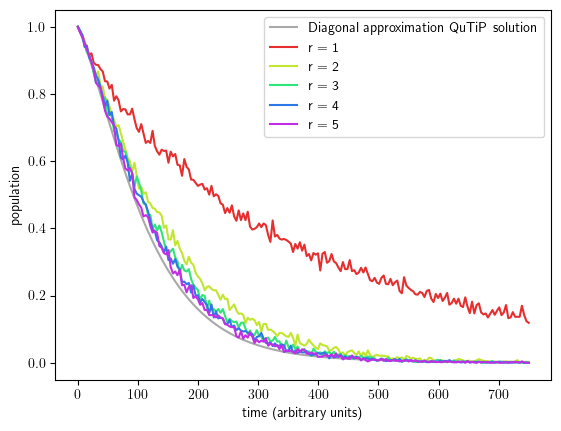

In [1]:
from tests.purely_dissipative_generalized_original_circuit import get_circuit
from main_functions.generalized_estimator_solver import estimator_solver
from tests.tests_generalized_ME_methods import solve_master_equation
from qiskit_aer import AerSimulator
from utils.generate_complementary_colors import generate_complementary_colors
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

omega_m = [1.2, 1.21]
omega_c = 1.1
gamma = [0.8*(10**-6)]*2
kappa = [0.2]
g = [0.03, 0.03]

initial_state = [0, 0, 0, 1]
t = np.linspace(0, 750, 200)

trotter = [1,2,3,4,5]
backend = AerSimulator()
optimization_level = 0
options = {'default_shots' : 10**3}

colors = generate_complementary_colors(len(trotter), palette_type='default')

evs_markovian = solve_master_equation(omega_m, omega_c, gamma, kappa, g, t, initial_state, 'diagonal', False)
plt.plot(t, evs_markovian['1'], linestyle = 'solid', color = 'darkgrey', label = 'Diagonal approximation QuTiP solution')

counter = 0

for r in trotter:
    qc = get_circuit(2, omega_m, omega_c, g, gamma, kappa, initial_state, r)
    evs_qiskit = estimator_solver(qc, 2, t, backend, optimization_level, options)

    plt.plot(t, evs_qiskit['1'], linestyle = 'solid', color = colors[counter], label = f'r = {r}' )
    counter = counter + 1

plt.ylabel('population')
plt.xlabel('time (arbitrary units)')
plt.legend()
#plt.savefig('figures/generalized_two_qubit_circuit_test_5_trotter.png', bbox_inches='tight')
plt.show()

Now, why is this happening? For example for $ k = 2$ and $k=3$, this would mean

$$
\begin{align}
\rho (t) = \sum_{j=0}^{3} K_j \left(\frac{t}{2} \right) \left( \sum_{i=0}^{3} K_i \left(\frac{t}{2} \right) \rho(0) K_i^{\dag} \left(\frac{t}{2} \right) \right) K_j^{\dag} \left(\frac{t}{2} \right) 
\end{align}

$$
\begin{align}
\rho (t) = \sum_{k=0}^{3} K_k \left(\frac{t}{3} \right) \left[ \sum_{j=0}^{3} K_j \left(\frac{t}{3} \right) \left( \sum_{i=0}^{3} K_i \left(\frac{t}{3} \right) \rho(0) K_i^{\dag} \left(\frac{t}{3} \right) \right) K_j^{\dag} \left(\frac{t}{3} \right) \right] K_k^{\dag} \left(\frac{t}{3} \right)
\end{align}

We can compute this explicitly

In [20]:
from utils.get_kraus_TEST import get_kraus
from sympy import Matrix, Symbol, sqrt, latex, Function
from IPython.display import display, Math
from sympy.physics.quantum import TensorProduct
from sympy import init_printing
init_printing()

ancilla_dim = 4
system_dim = 4

#time_slice = Symbol('t/k')

p_plus_e = Symbol('p_{+E}')
p_minus_e = Symbol('p_{-E}')
p_g_plus = Symbol('p_{G+}')
p_g_minus = Symbol('p_{G-}')

ket_0 = Matrix([[1],[0]])
ket_1 = Matrix([[0],[1]])

ket_00 = TensorProduct(ket_0, ket_0)
ket_01 = TensorProduct(ket_0, ket_1)
ket_10 = TensorProduct(ket_1, ket_0)
ket_11 = TensorProduct(ket_1, ket_1)

first_prime = TensorProduct(ket_00, ket_00) 
second_prime = sqrt(1-p_g_minus)*TensorProduct(ket_01, ket_00) + sqrt(p_g_minus)*TensorProduct(ket_00, ket_01)
third_prime = sqrt(1-p_g_plus)*TensorProduct(ket_10, ket_00) + sqrt(p_g_plus)*TensorProduct(ket_00, ket_10)
fourth_prime = sqrt(1-p_plus_e)*sqrt(1-p_minus_e)*TensorProduct(ket_11, ket_00) + sqrt(1 - p_plus_e)*sqrt(p_minus_e)*TensorProduct(ket_01, ket_10) + sqrt(1 - p_minus_e)*sqrt(p_plus_e)*TensorProduct(ket_10, ket_01) +sqrt(p_minus_e)*sqrt(p_plus_e)*TensorProduct(ket_00, ket_11) 

transformed_kets = [first_prime, second_prime, third_prime, fourth_prime]
basis = 'computational'

kraus = get_kraus(transformed_kets, basis, system_dim, ancilla_dim, True)
counter = 0
for k in kraus:
    eq_latex = f'K_{counter} = ' + latex(k)
    display(Math(eq_latex))
    counter = counter + 1

The channel is CPTP


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
from sympy import Matrix

symbol_data = []

for i in range(4):
    row = []

    for j in range(4):
        row.append(Symbol(f'rho_{i}{j}'))
    
    symbol_data.append(row)

rho = Matrix(symbol_data)
kraus_rho = kraus[0]*(rho*kraus[0].transpose()) + kraus[1]*(rho*kraus[1].transpose()) + kraus[2]*(rho*kraus[2].transpose()) + kraus[3]*(rho*kraus[3].transpose())
two_evolved_kraus_rho = kraus[0]*(kraus_rho*kraus[0].transpose()) + kraus[1]*(kraus_rho*kraus[1].transpose()) + kraus[2]*(kraus_rho*kraus[2].transpose()) + kraus[3]*(kraus_rho*kraus[3].transpose())

eq_latex = r'\rho_{Kraus}(t + \Delta t) = \sum_{i=0} K_i \left(\frac{t}{2} \right)' + latex(kraus_rho) + r'K_i^{\dag} \left(\frac{t}{2} \right) = ' + latex(two_evolved_kraus_rho)
display(Math(eq_latex))

<IPython.core.display.Math object>

In [23]:
print_latex(two_evolved_kraus_rho)

\left[\begin{matrix}p_{+E} p_{-E} \rho_{33} \cdot \left(1 - p_{+E}\right) \left(1 - p_{-E}\right) + p_{+E} p_{-E} \rho_{33} + p_{G+} \rho_{22} + p_{G+} \left(p_{+E} \rho_{33} \cdot \left(1 - p_{-E}\right) + \rho_{22} \cdot \left(1 - p_{G+}\right)\right) + p_{G-} \rho_{11} + p_{G-} \left(p_{-E} \rho_{33} \cdot \left(1 - p_{+E}\right) + \rho_{11} \cdot \left(1 - p_{G-}\right)\right) + \rho_{00} & \sqrt{p_{-E}} \sqrt{p_{G+}} \rho_{23} \cdot \left(1 - p_{+E}\right) \sqrt{1 - p_{-E}} \sqrt{1 - p_{G+}} + \sqrt{1 - p_{G-}} \left(\sqrt{p_{-E}} \sqrt{p_{G+}} \rho_{23} \sqrt{1 - p_{+E}} + \rho_{01} \sqrt{1 - p_{G-}}\right) & \sqrt{p_{+E}} \sqrt{p_{G-}} \rho_{13} \sqrt{1 - p_{+E}} \left(1 - p_{-E}\right) \sqrt{1 - p_{G-}} + \sqrt{1 - p_{G+}} \left(\sqrt{p_{+E}} \sqrt{p_{G-}} \rho_{13} \sqrt{1 - p_{-E}} + \rho_{02} \sqrt{1 - p_{G+}}\right) & \rho_{03} \cdot \left(1 - p_{+E}\right) \left(1 - p_{-E}\right)\\\sqrt{p_{-E}} \sqrt{p_{G+}} \rho_{32} \cdot \left(1 - p_{+E}\right) \sqrt{1 - p_{-E}} \sqrt{1

[WIP]

## Trotter error of the separation between unitary and dissipative evolutions.

[WIP]

## Diagonal approximation error 

[WIP]